In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import math

## Noise reduction

In [4]:
def noise_reduction(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

## Gradient reduction

In [5]:
from scipy import ndimage

def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

## Non-Maximum Suppression

In [6]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

## Double threshold

In [7]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

## Edge Tracking by Hysteresis

In [8]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

## Let's try it!

In [181]:
img = cv.imread("/home/thierry/code/zuzannaszu/chess_hacker/Raw_Data/data/0.jpg")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

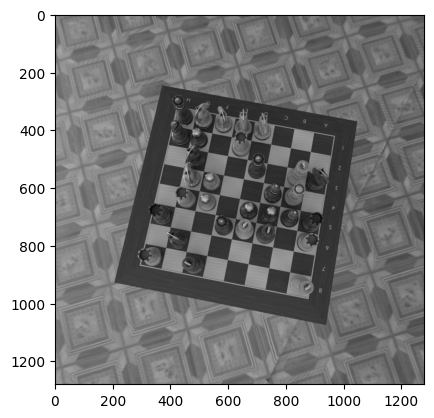

In [182]:
plt.imshow(img_gray,cmap="gray")

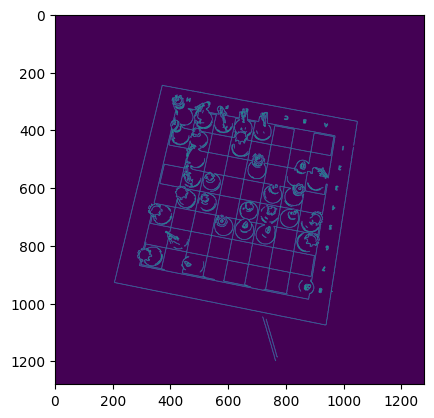

In [183]:
edges = cv.Canny(img_gray, 100, 200)
plt.imshow(edges)

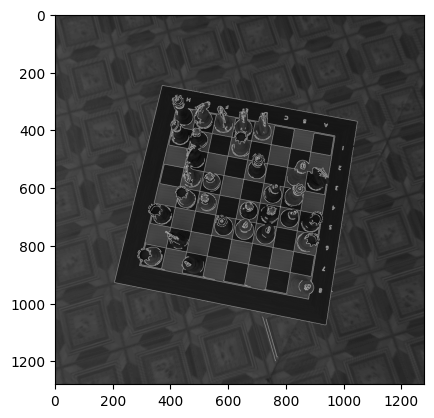

In [184]:
added_image = cv.addWeighted(img_gray,0.5,edges,1,0)
plt.imshow(added_image,cmap="gray")

In [197]:
img_gray_2 = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
lines = cv.HoughLines(edges, 1, np.pi/180, 152)

In [198]:
cartesian = []
if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            a = math.cos(theta)
            b = math.sin(theta)
            x0 = a * rho
            y0 = b * rho
            pt1 = (int(x0 + 1500*(-b)), int(y0 + 1500*(a)))
            pt2 = (int(x0 - 1500*(-b)), int(y0 - 1500*(a)))
            cartesian.append((rho*math.cos(theta), rho*math.sin(theta)))
            cv.line(img_gray_2, pt1, pt2, (0,0,255), 3, cv.LINE_AA)

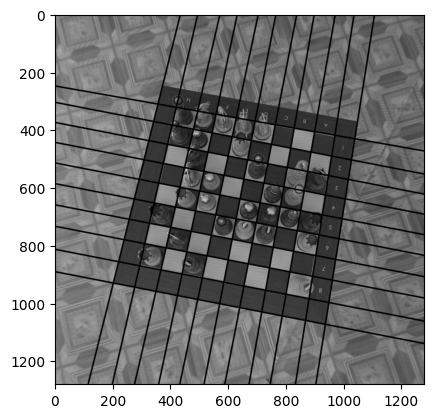

In [199]:
plt.imshow(img_gray_2,cmap="gray")

## Hough lines conversion